In [80]:
import numpy as np 
import SC_search
import matplotlib.pyplot as plt
import scienceplots 
import matplotlib
import itertools
matplotlib.rcParams.update({'font.size': 20})
plt.style.use('science')


In [81]:
# Frequency domain setup
year_in_seconds = 365.25*24*60*60

# Frequency bounds
f_low = 0.018
f_high = 0.03



T_obs = (3*year_in_seconds)
d = 1/(T_obs)
safety = 10
cadence = 2/(f_high*safety)

freqs = np.arange(0.015,f_high+d,d)


In [3]:
Sdisp = SC_search.Noise.Sdisp_SciRD(freqs)
Sopt = SC_search.Noise.Sopt_SciRD(freqs)
psd_A = SC_search.Noise.psd_AEX(freqs,Sdisp,Sopt)
psd_E = SC_search.Noise.psd_AEX(freqs,Sdisp,Sopt)
psd_T = SC_search.Noise.psd_TX(freqs,Sdisp,Sopt)

global psd_array
psd_array = np.array([psd_A,psd_E,psd_T])

In [4]:
source_parameters = np.array([28.09555579546043,#mc [sm]
                    0.24710059171597634,#eta
                    50.1*(1.e+6),#D
                    np.pi/4,#beta [rads]
                    2.01,#lambda [rads]
                    2.498091544796509,#inc [rads]
                    -1.851592653589793,#polarization [rads]
                    0,#phi0 [rads]
                    0.018/2,
                    0.01])#e0

finite_differences = np.array([0.00001,#mc
                      0,#eta
                      0,#D       
                      0.001,#beta
                      0.001,#lambda
                      0,#inc
                      0,#pol
                      0,#phi0
                      1e-8,#f_low # Might need to be lower
                      1e-3])#e0

phasing_param_indexes = np.array([0,#mc
                         3,#beta
                         4,#lambda
                         8,#f_low
                         9])#e0



In [5]:
source_params_transformed = SC_search.Utility.TaylorF2Ecc_mc_eta_to_m1m2(source_parameters.copy())
# Use interpolation functionality from BBHx
freqs_sparse = freqs[::1000]
injection_signal= SC_search.Waveforms.TaylorF2Ecc.BBHx_response_interpolate_CPU(source_params_transformed,
                                                                                  freqs_sparse,
                                                                                  freqs,
                                                                                  f_high,
                                                                                  T_obs,
                                                                                  'AET',
                                                                                  logging=True)


Time to merger is:  3.5550937742535975  years
Upper bound on time in band:  2.6438861012726447  years (no eccentricity evolution assumed)


In [82]:
def waveform_generation(parameters):
    '''
    Generate a waveform 
    '''
    params_transformed = SC_search.Utility.TaylorF2Ecc_mc_eta_to_m1m2(parameters.copy())
    wf = SC_search.Waveforms.TaylorF2Ecc.BBHx_response_interpolate_CPU(params_transformed,
                                                                                  freqs_sparse,
                                                                                  freqs,
                                                                                  f_high,
                                                                                  T_obs,
                                                                                  'AET',
                                                                                  logging=False)
    return(wf)
    
def second_derivative(params,indexes,num_segments):
    '''
    Compute numerical derivatives of the waveforms for computation of the metric on the parameter space wrt the semi-coherent match 
    '''

    # If g_ii term
    
    if indexes[0] == indexes[1]:

        forward = params.copy()
        backward = params.copy()
        
        forward[indexes[0]] += finite_differences.copy()[indexes[0]]
        backward[indexes[0]] -= finite_differences.copy()[indexes[0]]
        
        forward_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward.copy()),
                                                                             waveform_generation(params.copy()),
                                                                              psd_array,d,num_segments=num_segments)
                        
        backward_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward.copy()),
                                                                              waveform_generation(params.copy()),
                                                                              psd_array,d,num_segments=num_segments)
                         
        central_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(params.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)  
        
        
        der = (forward_term+backward_term-2*central_term)/np.abs(finite_differences.copy()[indexes[0]])**2
        
    else:
    # If g_ij
        forward_i_j = params.copy()
        backward_i_j = params.copy()
        forward_i = params.copy()
        forward_j = params.copy()
        backward_i = params.copy()
        backward_j = params.copy()


        
        forward_i_j[indexes] += finite_differences.copy()[indexes]
        backward_i_j[indexes] -= finite_differences.copy()[indexes]

        forward_i[indexes[0]] += finite_differences.copy()[indexes[0]]
        forward_j[indexes[1]] += finite_differences.copy()[indexes[1]]

        backward_i[indexes[0]] -= finite_differences.copy()[indexes[0]]
        backward_j[indexes[1]] -= finite_differences.copy()[indexes[1]]

        forward_ij_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward_i_j.copy()),
                                                                                  waveform_generation(params.copy()),                                                                                  
                                                                                  psd_array,d,num_segments=num_segments)
                           
        backward_ij_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward_i_j.copy()),
                                                                                  waveform_generation(params.copy()), 
                                                                                  psd_array,d,num_segments=num_segments)

        forward_i_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward_i.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)                            

        forward_j_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(forward_j.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)     
                          
        backward_i_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward_i.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)                            

        backward_j_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(backward_j.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)                            
        
        central_term = SC_search.Semi_Coherent_Functions.semi_coherent_match(waveform_generation(params.copy()),
                                                                                  waveform_generation(params.copy()),
                                                                                  psd_array,d,num_segments=num_segments)  
        
        der = 1/(2*finite_differences.copy()[indexes[0]]*finite_differences.copy()[indexes[1]])*(forward_ij_term
                                                                                                 -forward_i_term
                                                                                                 -forward_j_term
                                                                                                 +2*central_term
                                                                                                 -backward_i_term
                                                                                                 -backward_j_term
                                                                                                 +backward_ij_term)
        
    return(der)
    
def generate_metric(params,num_segments):
    '''
    Generate metric over all the phasing parameter. Put zeros in the spots for the other parameters.
    '''

    # Empty metric array
    g_ij = np.zeros((params.size,params.size))
    
    for i in phasing_param_indexes:
        for j in phasing_param_indexes:
            index_pairs = (i,j)
            g_ij[index_pairs] = -1/2*second_derivative(params.copy(),np.array(index_pairs),num_segments)
    
    return(g_ij)

def subset_metric(g_ij_whole):
    '''
    Postprocess the metric down to just the phasing parameters. 
    '''
    
    g_ij_subset = np.zeros((phasing_param_indexes.size,phasing_param_indexes.size))
    
    for subset_index_i,i in enumerate(phasing_param_indexes):
        for subset_index_j,j in enumerate(phasing_param_indexes):
            g_ij_subset[subset_index_i,subset_index_j] = g_ij_whole[i,j]
            
    return(g_ij_subset)

In [35]:
# Compute metrics at a number of segments around the injection point
g_1 = subset_metric(generate_metric(source_parameters,1))
g_10 = subset_metric(generate_metric(source_parameters,10))
g_100 = subset_metric(generate_metric(source_parameters,100))
g_1000 = subset_metric(generate_metric(source_parameters,1000))

In [63]:
SNR_squared = 4*np.real(np.sum(injection_signal*injection_signal.conj()/psd_array*d))
SNR = np.sqrt(SNR_squared)
SNR

38.031644871668014

In [83]:
# Width of peak in every dimension, ignoring covariances 
print(np.sqrt(np.diag(np.linalg.inv(g_1)/(2*SNR))))
print(np.sqrt(np.diag(np.linalg.inv(g_10)/(2*SNR))))
print(np.sqrt(np.diag(np.linalg.inv(g_100)/(2*SNR))))
print(np.sqrt(np.diag(np.linalg.inv(g_1000)/(2*SNR))))

[3.09511775e-06 4.90908067e-03 5.13776130e-03 1.54574412e-09
 1.35211252e-04]
[1.59730690e-05 9.72428573e-03 1.02306378e-02 2.36905112e-09
 1.25627412e-04]
[4.32688480e-04 7.27908891e-02 9.75529046e-02 5.44078423e-08
 2.06073334e-04]
[6.00323283e-03 1.94537110e-01 2.39480312e-01 5.65757234e-07
 2.91883137e-03]


In [84]:
#Mc,beta,lambda,f_low,e0

Keeping in mind this is sort of a lower limit to the width at each segment, I think.

In [70]:
widths_1 = np.sqrt(np.diag(np.linalg.inv(g_1)/(2*SNR)))
widths_10 = np.sqrt(np.diag(np.linalg.inv(g_10)/(2*SNR)))
widths_100 = np.sqrt(np.diag(np.linalg.inv(g_100)/(2*SNR)))
widths_1000 = np.sqrt(np.diag(np.linalg.inv(g_1000)/(2*SNR)))
N = [1,10,100,1000]

Text(0, 0.5, '$\\sigma(\\mathcal{M}_c)$')

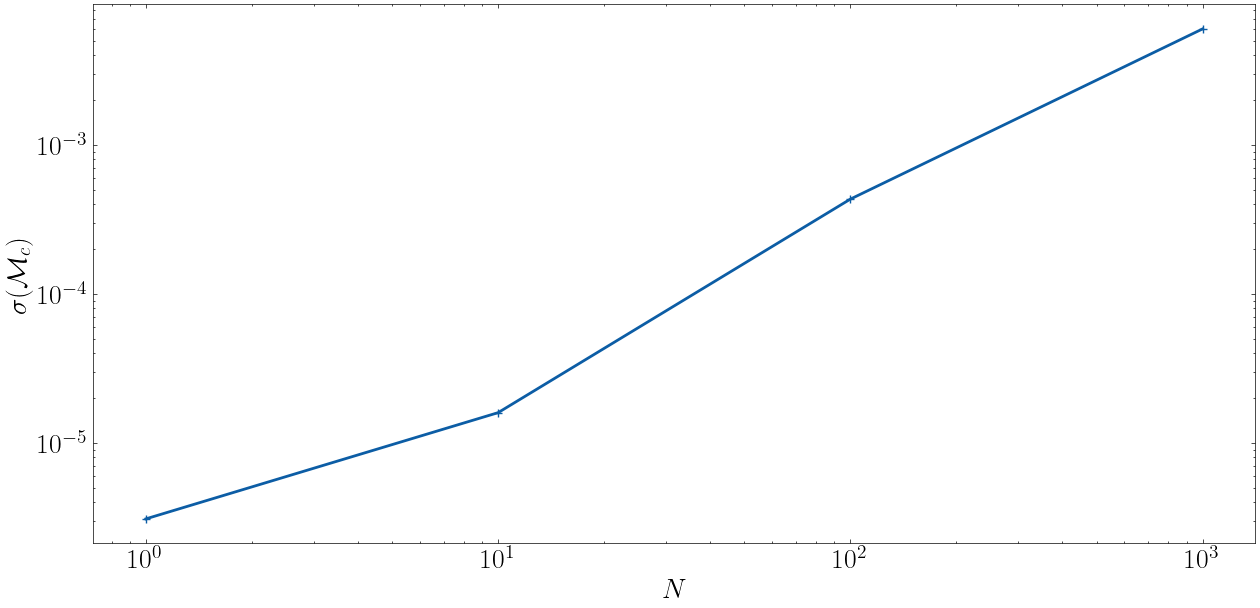

In [88]:
plt.figure(figsize=(15,7))
plt.loglog(N,[widths_1[0],
            widths_10[0],
            widths_100[0],
            widths_1000[0]],marker='+',lw=2)
plt.xlabel(r'$N$')
plt.ylabel(r'$\sigma(\mathcal{M}_c)$')